In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('datasets/american_bankruptcy.csv')
data.head()

In [ ]:
# Data preprocessing
X = data.drop(['status_label','company_name', "year"], axis=1)  # Features
y = data['status_label']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)

In [ ]:
model = LGBMClassifier()
model.fit(X_train_scaled, y_train)
 
pred = model.predict(X_test_scaled)
print(pred)

In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train_scaled,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test_scaled,y_test)))

In [ ]:
print(metrics.classification_report(y_test,model.predict(X_test_scaled)))

<font size="6">Testing LightGBM model with GBQ Table</font>

In [ ]:
import pandas as pd
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq
credentials_path = 'data_cleaning/token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [ ]:
project_id = 'capstone-402105'
dataset_id = 'capstone'
table_id = "CRI-Compustat-Merged-Ryan"

In [ ]:
from pandas_gbq import read_gbq

query = f"""
SELECT *
FROM `{project_id}.{dataset_id}.{table_id}`

"""

# Authenticate and read data from BigQuery into a DataFrame
df = read_gbq(query, project_id=project_id, dialect='standard')
df

In [ ]:
len(df.gvkey.unique())


In [ ]:
test_df = df

In [ ]:
test_df.isna().sum().sort_values(ascending=False)

In [ ]:
test_df['EventType'] = test_df['EventType'].map(lambda x : 0 if x ==2  else x)

In [ ]:
test_df['EventType'].value_counts()

In [ ]:
test_df.dtypes

In [ ]:
test_df.select_dtypes(exclude=['float'])

In [ ]:
test_df[['gvkey', 'sic']] = test_df[['gvkey', 'sic']].astype(float)

In [ ]:
X = test_df.drop(['EventType', 'EventDate_string', 'yyyy', 'mm', 'Duration', 'EventDate', 'StartDate', 'datadate', 'tic'], axis=1)  # Features
y = test_df['EventType']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class_weights = {0:1, 1:100}
model = LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=22)
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

In [ ]:
pred_binary = np.round(pred)

In [ ]:
#plot aucroc
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
confusion = confusion_matrix(y_test, pred_binary)
ConfusionMatrixDisplay(confusion).plot()

<font size="6">Testing PHD Code</font>

In [2]:
import pandas as pd

In [3]:
#load cri merged
cri_data = pd.read_pickle('CRI_xy_PHD.pkl')
cri_data.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,m2b,sigma,liqfinlevel,lqfintrend,DTDmedianFin,DTDmedianNonFin,dummy297fin,Default,day,date
489123,29823000.0,1991.0,1,0.045126,0.013825,1.810500,0.0,0.983576,-0.268833,0.003667,...,0.628782,0.221843,0.0,0.0,0.0,2.812531,0,0,1,1991-01-01
1714449,125959000.0,1991.0,1,0.045126,0.013825,7.910572,0.0,0.538243,0.018112,0.016005,...,3.515291,0.083693,0.0,0.0,0.0,2.812531,0,0,1,1991-01-01
64808,27304000.0,1991.0,1,0.045126,0.013825,6.080297,0.0,0.582996,-0.042528,0.006643,...,1.674587,0.075069,0.0,0.0,0.0,2.812531,0,0,1,1991-01-01
192576,27954000.0,1991.0,1,0.045126,0.013825,2.527857,0.0,1.041157,-0.129895,-0.010749,...,1.075097,0.191047,0.0,0.0,0.0,2.812531,0,0,1,1991-01-01
539304,30244000.0,1991.0,1,0.045126,0.013825,4.337317,0.0,0.656583,0.193871,0.007802,...,2.520483,0.182062,0.0,0.0,0.0,2.812531,0,0,1,1991-01-01


In [22]:
#load compustat clean
compustat_data = pd.read_pickle('compustat_vin.pkl')
compustat_data.head()

,gvkey,datadate,cik,tic,sic,current_ratio,quick_ratio,cash_ratio,net_working_capital,debt_ratio,...,price_to_earnings_inf,gross_margin_ratio_inf,receivables_turnover_inf,days_in_inventory_inf,retention_ratio_inf,dividend_payout_ratio_inf,debt_to_equity_ratio_inf,working_capital_turnover_inf,yyyy,mm
0,1004,2000-05-31,1750.0,AIR,5080.0,3.120983,1.069792,-0.042786,347.451,0.279030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,5
1,1004,2000-06-30,1750.0,AIR,5080.0,3.120983,1.069792,-0.042786,347.451,0.279030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,6
2,1004,2000-07-31,1750.0,AIR,5080.0,3.120983,1.069792,-0.042786,347.451,0.279030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,7
3,1004,2000-08-31,1750.0,AIR,5080.0,3.032279,0.989191,-0.003399,341.996,0.305692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,8
4,1004,2000-09-30,1750.0,AIR,5080.0,3.032279,0.989191,-0.003399,341.996,0.305692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,9


In [5]:
print(compustat_data.shape)
print(cri_data.shape)

(2226315, 49)
(2240223, 23)


In [6]:
company_map = pd.read_excel('compustat_company_map.xlsx')
company_map.head()

,company_number,gvkey
0,50797,177439
1,92318,160317
2,92300,106156
3,45321,141466
4,43665,66636


In [7]:
# Format comp no 
cri_data['CompNo_formatted'] = cri_data['CompNo'].apply(lambda x: int(x / 1000))

In [8]:
# mapping from company number to gvkey
mapping_dict = company_map.set_index('company_number')['gvkey'].to_dict()

In [9]:
cri_data['gvkey'] = cri_data['CompNo_formatted'].map(mapping_dict)

In [10]:
cri_data = cri_data.dropna()
cri_data.shape

(1943733, 25)

In [23]:
# clean compustat
compustat_data.rename(columns = {'mm': 'month'}, inplace=True)
compustat_data.rename(columns = {'yyyy': 'year'}, inplace=True)
compustat_data.drop(columns = ['datadate', 'tic', 'sic', 'quarter'], inplace=True)
compustat_data

,gvkey,cik,current_ratio,quick_ratio,cash_ratio,net_working_capital,debt_ratio,debt_to_equity_ratio,equity_ratio,cashflow_to_debt_ratio,...,price_to_earnings_inf,gross_margin_ratio_inf,receivables_turnover_inf,days_in_inventory_inf,retention_ratio_inf,dividend_payout_ratio_inf,debt_to_equity_ratio_inf,working_capital_turnover_inf,year,month
0,1004,1750.0,3.120983,1.069792,-0.042786,347.451,0.279030,0.608989,0.458186,0.048612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,5
1,1004,1750.0,3.120983,1.069792,-0.042786,347.451,0.279030,0.608989,0.458186,0.048612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,6
2,1004,1750.0,3.120983,1.069792,-0.042786,347.451,0.279030,0.608989,0.458186,0.048612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,7
3,1004,1750.0,3.032279,0.989191,-0.003399,341.996,0.305692,0.673592,0.453824,-0.033884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,8
4,1004,1750.0,3.032279,0.989191,-0.003399,341.996,0.305692,0.673592,0.453824,-0.033884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226310,353945,1948862.0,2.519278,1.777203,-0.005182,62.102,0.123077,0.113801,0.583091,0.056385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,8
2226311,353945,1948862.0,2.510161,1.799795,-0.002064,63.463,0.120438,0.109377,0.584569,0.103570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,9
2226312,353945,1948862.0,2.510161,1.799795,-0.002064,63.463,0.120438,0.109377,0.584569,0.103570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,10
2226313,353945,1948862.0,2.510161,1.799795,-0.002064,63.463,0.120438,0.109377,0.584569,0.103570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022,11


In [19]:
cri_data.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'Default', 'day',
       'date', 'CompNo_formatted', 'gvkey'],
      dtype='object')

In [24]:
compustat_data.columns

Index(['gvkey', 'cik', 'current_ratio', 'quick_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings', 'retention_ratio',
       'gross_margin_ratio', 'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'dividend_payout_ratio', 'sector_industry', 'inventory_turnover_inf',
       'debt_service_coverage_ratio_inf', 'cashflow_to_debt_ratio_inf',
       'interest_coverage_ratio_inf', 'net_profit_margin_inf',
       'operating_profit_margin_inf', 'ebitda_margin_inf',
       'day_sales_outstanding_inf', 'price_to_earnings_inf',
       'gross_margin_ratio_inf', 'receivables_turnover_inf',
       'days_in_inventory_inf', 'retention_

In [25]:
# inner join on gvkey, year, month where left is CRI data, right is compustat
cri_compustat_merged = cri_data.merge(compustat_data, on=['gvkey', 'year', 'month'], how='inner')


In [26]:
cri_compustat_merged.shape

(1143387, 67)

In [27]:
cri_compustat_merged.head()

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,ebitda_margin_inf,day_sales_outstanding_inf,price_to_earnings_inf,gross_margin_ratio_inf,receivables_turnover_inf,days_in_inventory_inf,retention_ratio_inf,dividend_payout_ratio_inf,debt_to_equity_ratio_inf,working_capital_turnover_inf
0,27809000.0,2000.0,3,0.164517,0.011801,4.228806,1.067829,-0.082247,-0.391751,-0.000246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36858001.0,2000.0,3,0.164517,0.011801,7.526516,0.661114,1.593042,0.135539,0.021708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38263005.0,2000.0,3,0.164517,0.011801,1.988268,-0.856836,1.735740,0.007481,-0.003181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35535000.0,2000.0,3,0.164517,0.011801,3.043216,0.272535,1.106130,0.541976,-0.002146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32732000.0,2000.0,3,0.164517,0.011801,3.006225,0.211347,2.032667,-0.093195,-0.003874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
cri_compustat_merged.CompNo.nunique()

11177

In [29]:
cri_compustat_merged.isna().sum().sort_values(ascending=False)

CompNo                          0
sector_industry                 0
asset_turnover                  0
inventory_turnover              0
days_in_inventory               0
                               ..
cash_ratio                      0
net_working_capital             0
debt_ratio                      0
debt_to_equity_ratio            0
working_capital_turnover_inf    0
Length: 67, dtype: int64

In [30]:
data = cri_compustat_merged.copy()

In [31]:
data

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,ebitda_margin_inf,day_sales_outstanding_inf,price_to_earnings_inf,gross_margin_ratio_inf,receivables_turnover_inf,days_in_inventory_inf,retention_ratio_inf,dividend_payout_ratio_inf,debt_to_equity_ratio_inf,working_capital_turnover_inf
0,27809000.0,2000.0,3,0.164517,0.011801,4.228806,1.067829,-0.082247,-0.391751,-0.000246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36858001.0,2000.0,3,0.164517,0.011801,7.526516,0.661114,1.593042,0.135539,0.021708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38263005.0,2000.0,3,0.164517,0.011801,1.988268,-0.856836,1.735740,0.007481,-0.003181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35535000.0,2000.0,3,0.164517,0.011801,3.043216,0.272535,1.106130,0.541976,-0.002146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32732000.0,2000.0,3,0.164517,0.011801,3.006225,0.211347,2.032667,-0.093195,-0.003874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143382,27334000.0,2023.0,7,0.110445,0.009928,4.813408,1.285527,-0.311802,0.041775,0.008093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1143383,32388000.0,2023.0,7,0.110445,0.009928,3.637767,1.072696,0.114648,-0.005109,0.018388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1143384,27348000.0,2023.0,7,0.110445,0.009928,3.124164,0.535792,0.738567,0.004386,0.020075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1143385,27136000.0,2023.0,7,0.110445,0.009928,3.328665,1.573513,-0.025210,0.006575,0.006587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
 #replace inf and -inf values with 0
# import numpy as np
# data.replace([np.inf, -np.inf], 0, inplace=True)
# data

In [36]:
data['Default'].value_counts()

Default
0    1134107
1       9280
Name: count, dtype: int64

In [39]:
data.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'Default', 'day',
       'date', 'CompNo_formatted', 'gvkey', 'cik', 'current_ratio',
       'quick_ratio', 'cash_ratio', 'net_working_capital', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_ratio', 'cashflow_to_debt_ratio',
       'net_profit_margin', 'return_on_assets', 'asset_turnover',
       'inventory_turnover', 'days_in_inventory', 'receivables_turnover',
       'day_sales_outstanding', 'working_capital_turnover',
       'price_to_earnings', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'dividend_payout_ratio', 'sector_industry', 'inventory_turnover_inf',
       'debt_service_c

In [40]:
data.dtypes

CompNo                          float64
year                            float64
month                             int64
StkIndx                         float64
STInt                           float64
                                 ...   
days_in_inventory_inf           float64
retention_ratio_inf             float64
dividend_payout_ratio_inf       float64
debt_to_equity_ratio_inf        float64
working_capital_turnover_inf    float64
Length: 67, dtype: object

In [ ]:
#data['EventType'] = test_df['EventType'].map(lambda x : 0 if x ==2  else x)

In [ ]:
#data[['gvkey', 'sic']] = data[['gvkey', 'sic']].astype(float)

In [46]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [42]:
data['sector_industry'] = data['sector_industry'].astype(float)

In [44]:
X = data.drop(['Default', 'date'], axis=1)  # Features
y = data['Default']  # Target

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [52]:
inf_count = data.isin([np.inf, -np.inf]).mean() * 100
inf_count.sort_values(ascending=False)

inventory_turnover              26.315937
debt_service_coverage_ratio     14.465443
cashflow_to_debt_ratio          14.278280
interest_coverage_ratio          8.500446
net_profit_margin                3.280254
                                  ...    
quick_ratio                      0.000000
cash_ratio                       0.000000
net_working_capital              0.000000
debt_ratio                       0.000000
working_capital_turnover_inf     0.000000
Length: 67, dtype: float64

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled  = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [53]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
x_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1  # 95% of variance

x_train_pca = X_train_pca [:, :n_components]
x_val_pca = x_val_pca[:, :n_components]
x_test_pca = X_test_pca[:, :n_components]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train.squeeze().astype('category').cat.codes, cmap='viridis', alpha=0.6)
plt.title('Scatter Plot of Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target')
plt.grid(True)
plt.show()

In [55]:
# WARNING: 2 changes to change evaluation metric

optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'precision', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        #'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0), --> 1.0 is what we want
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'scale_pos_weight': 100
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(X_train, y_train), num_boost_round=500)
    
    preds = gbm.predict(X_val)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_val, preds)
    accuracy = accuracy_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    precision = precision_score(y_val, y_pred_binary)
    f1 = f1_score(y_val, y_pred_binary)
    #choose the metric you want to optimized

    if optimisation_metric == "auc":
        return auc
    elif optimisation_metric == "recall":
        return recall
    elif optimisation_metric == "precision":
        return precision
    elif optimisation_metric == "f1":
        return f1
    else:
        return auc

'''
    match optimisation_metric:
        case "auc":
            return auc
        case "recall":
            return recall
        case "precision":
            return precision
        case "f1":
            return f1
        case _:
            return auc
    return auc
'''

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params


[I 2023-10-22 21:34:06,021] A new study created in memory with name: no-name-bf152102-262f-46e9-900c-d04ffe313109


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 21:34:35,429] Trial 0 finished with value: 0.7997082770278561 and parameters: {'num_leaves': 208, 'lambda_l1': 0.1031748148243036, 'lambda_l2': 3.353871278034884e-08, 'bagging_fraction': 0.4763859600323567, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 0 with value: 0.7997082770278561.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:35:07,902] Trial 1 finished with value: 0.9855205519674147 and parameters: {'num_leaves': 57, 'lambda_l1': 0.3681587326334624, 'lambda_l2': 2.686571069198793, 'bagging_fraction': 0.5251053210311445, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 1 with value: 0.9855205519674147.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 21:36:34,974] Trial 2 finished with value: 0.995038554728093 and parameters: {'num_leaves': 202, 'lambda_l1': 5.225299746358865, 'lambda_l2': 5.409908182148332, 'bagging_fraction': 0.8246351970522763, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:37:01,943] Trial 3 finished with value: 0.9785141582637278 and parameters: {'num_leaves': 32, 'lambda_l1': 0.15216993447154192, 'lambda_l2': 0.005968640703152713, 'bagging_fraction': 0.8617558664429973, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:37:22,628] Trial 4 finished with value: 0.9836403914645722 and parameters: {'num_leaves': 18, 'lambda_l1': 2.772552389002691e-08, 'lambda_l2': 0.00019255259505435296, 'bagging_fraction': 0.9657416139417505, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 21:38:13,134] Trial 5 finished with value: 0.8286232758585819 and parameters: {'num_leaves': 230, 'lambda_l1': 2.6426269825272917e-07, 'lambda_l2': 1.5477258025299756e-06, 'bagging_fraction': 0.7229131246849174, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-10-22 21:39:39,948] Trial 6 finished with value: 0.9811857140167608 and parameters: {'num_leaves': 200, 'lambda_l1': 0.34454669583164604, 'lambda_l2': 0.504377723732675, 'bagging_fraction': 0.6990752716379993, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 21:40:36,910] Trial 7 finished with value: 0.7457443349322456 and parameters: {'num_leaves': 211, 'lambda_l1': 1.219792550473366e-05, 'lambda_l2': 3.5059158117798887e-07, 'bagging_fraction': 0.7309064784568433, 'bagging_freq': 3, 'min_child_samples': 87}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2023-10-22 21:41:39,155] Trial 8 finished with value: 0.5383460354892083 and parameters: {'num_leaves': 175, 'lambda_l1': 1.284416086910249e-08, 'lambda_l2': 0.00027871472967445194, 'bagging_fraction': 0.6783170028972516, 'bagging_freq': 7, 'min_child_samples': 24}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2023-10-22 21:42:23,723] Trial 9 finished with value: 0.8061194160976108 and parameters: {'num_leaves': 96, 'lambda_l1': 1.54403616769576e-08, 'lambda_l2': 1.870205944622434e-07, 'bagging_fraction': 0.5034099883539025, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 21:43:39,986] Trial 10 finished with value: 0.9817555806995987 and parameters: {'num_leaves': 143, 'lambda_l1': 7.394751836470274, 'lambda_l2': 4.662755353803508, 'bagging_fraction': 0.982868564710778, 'bagging_freq': 5, 'min_child_samples': 69}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:44:38,245] Trial 11 finished with value: 0.9890639153034043 and parameters: {'num_leaves': 92, 'lambda_l1': 0.0024875479188058458, 'lambda_l2': 9.904243934660329, 'bagging_fraction': 0.5667321382902983, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:45:34,171] Trial 12 finished with value: 0.976778374139243 and parameters: {'num_leaves': 108, 'lambda_l1': 0.0011001638637524358, 'lambda_l2': 0.13247346854628686, 'bagging_fraction': 0.5933899365999347, 'bagging_freq': 1, 'min_child_samples': 99}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:46:49,073] Trial 13 finished with value: 0.9814749330397596 and parameters: {'num_leaves': 150, 'lambda_l1': 0.0015428565486405765, 'lambda_l2': 7.195320912519688, 'bagging_fraction': 0.8143387155602267, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 21:47:44,336] Trial 14 finished with value: 0.8854755081643387 and parameters: {'num_leaves': 255, 'lambda_l1': 0.007607542333870824, 'lambda_l2': 0.08099099312821471, 'bagging_fraction': 0.4054846878717377, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:48:20,617] Trial 15 finished with value: 0.945900204526465 and parameters: {'num_leaves': 59, 'lambda_l1': 5.149919722386972e-05, 'lambda_l2': 0.013565183465405993, 'bagging_fraction': 0.6146292955937873, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11343
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:49:19,585] Trial 16 finished with value: 0.9782839851690913 and parameters: {'num_leaves': 107, 'lambda_l1': 7.0665844775328726, 'lambda_l2': 7.844433053992443, 'bagging_fraction': 0.7858265456955871, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:50:30,133] Trial 17 finished with value: 0.9863267288508317 and parameters: {'num_leaves': 175, 'lambda_l1': 0.014706950738063362, 'lambda_l2': 0.5807439127533661, 'bagging_fraction': 0.8813875230436314, 'bagging_freq': 6, 'min_child_samples': 87}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:51:09,865] Trial 18 finished with value: 0.8884412705015146 and parameters: {'num_leaves': 75, 'lambda_l1': 0.0001446351665675749, 'lambda_l2': 0.003959308651812489, 'bagging_fraction': 0.6036061734171462, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:52:09,205] Trial 19 finished with value: 0.982612250749267 and parameters: {'num_leaves': 125, 'lambda_l1': 2.104400444792658, 'lambda_l2': 0.738339423992833, 'bagging_fraction': 0.6427050356972306, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:53:15,370] Trial 20 finished with value: 0.9681623647430646 and parameters: {'num_leaves': 169, 'lambda_l1': 0.022894074374239463, 'lambda_l2': 0.06926806085844914, 'bagging_fraction': 0.9208530766404817, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:54:40,604] Trial 21 finished with value: 0.9896728119463235 and parameters: {'num_leaves': 185, 'lambda_l1': 0.008990964614404932, 'lambda_l2': 0.8758707943599756, 'bagging_fraction': 0.863248510577235, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:56:04,520] Trial 22 finished with value: 0.993990058265354 and parameters: {'num_leaves': 190, 'lambda_l1': 0.0021884465235360445, 'lambda_l2': 1.8288822277072336, 'bagging_fraction': 0.7809729744458563, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 21:57:40,240] Trial 23 finished with value: 0.9894382378436065 and parameters: {'num_leaves': 237, 'lambda_l1': 0.03506941127543112, 'lambda_l2': 0.6223361824149795, 'bagging_fraction': 0.7883372224110212, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 21:59:02,434] Trial 24 finished with value: 0.9918752926580469 and parameters: {'num_leaves': 196, 'lambda_l1': 1.4225664376773044, 'lambda_l2': 1.5896562472346742, 'bagging_fraction': 0.8456068709025417, 'bagging_freq': 6, 'min_child_samples': 90}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 22:00:28,638] Trial 25 finished with value: 0.9944008090989842 and parameters: {'num_leaves': 228, 'lambda_l1': 1.4057746426405373, 'lambda_l2': 2.1858618485908536, 'bagging_fraction': 0.8096425089978633, 'bagging_freq': 7, 'min_child_samples': 78}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2023-10-22 22:01:45,662] Trial 26 finished with value: 0.9744217304174988 and parameters: {'num_leaves': 227, 'lambda_l1': 0.8396544017281422, 'lambda_l2': 0.12736313007240405, 'bagging_fraction': 0.7663340319352584, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2023-10-22 22:02:50,687] Trial 27 finished with value: 0.9901068016899088 and parameters: {'num_leaves': 255, 'lambda_l1': 9.94339292468353, 'lambda_l2': 2.096048477747262, 'bagging_fraction': 0.7595325105345937, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:04:06,581] Trial 28 finished with value: 0.9693187410868891 and parameters: {'num_leaves': 157, 'lambda_l1': 0.0633689355110376, 'lambda_l2': 0.020985269754983146, 'bagging_fraction': 0.8025201320927675, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:05:05,338] Trial 29 finished with value: 0.9810090958209627 and parameters: {'num_leaves': 211, 'lambda_l1': 0.13732160112234587, 'lambda_l2': 0.28257360131103226, 'bagging_fraction': 0.9207870854656716, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:06:33,611] Trial 30 finished with value: 0.9803623572049277 and parameters: {'num_leaves': 219, 'lambda_l1': 1.3021029592531208, 'lambda_l2': 9.830659953664535, 'bagging_fraction': 0.8170121639766612, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2023-10-22 22:07:59,280] Trial 31 finished with value: 0.9901973788756576 and parameters: {'num_leaves': 204, 'lambda_l1': 2.205547993077191, 'lambda_l2': 1.8241430661711442, 'bagging_fraction': 0.8372581679599704, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:09:28,343] Trial 32 finished with value: 0.9932197838857266 and parameters: {'num_leaves': 191, 'lambda_l1': 0.48877498001084435, 'lambda_l2': 2.0339377020568605, 'bagging_fraction': 0.7590570508494205, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:10:53,740] Trial 33 finished with value: 0.9938953516468327 and parameters: {'num_leaves': 188, 'lambda_l1': 0.30195898522849507, 'lambda_l2': 2.1936474322047106, 'bagging_fraction': 0.7431248795952173, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:12:34,913] Trial 34 finished with value: 0.994164573302599 and parameters: {'num_leaves': 245, 'lambda_l1': 0.18213298858373564, 'lambda_l2': 2.899375826986869, 'bagging_fraction': 0.7283845028116513, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2023-10-22 22:14:13,541] Trial 35 finished with value: 0.9825320901506911 and parameters: {'num_leaves': 239, 'lambda_l1': 0.16440033590651953, 'lambda_l2': 0.34390663006611055, 'bagging_fraction': 0.7025189385060103, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 2 with value: 0.995038554728093.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:15:59,109] Trial 36 finished with value: 0.9952926748125982 and parameters: {'num_leaves': 244, 'lambda_l1': 0.04238570083224051, 'lambda_l2': 2.722093235849198, 'bagging_fraction': 0.7871196542803091, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 36 with value: 0.9952926748125982.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 22:16:53,980] Trial 37 finished with value: 0.6525075787058044 and parameters: {'num_leaves': 244, 'lambda_l1': 0.0762273289275915, 'lambda_l2': 0.0012244154998444195, 'bagging_fraction': 0.7288938678281618, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 36 with value: 0.9952926748125982.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 22:18:22,447] Trial 38 finished with value: 0.9556950590930139 and parameters: {'num_leaves': 221, 'lambda_l1': 0.5136871420139658, 'lambda_l2': 0.03430939041573768, 'bagging_fraction': 0.6629430821378578, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 36 with value: 0.9952926748125982.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 22:19:42,303] Trial 39 finished with value: 0.9740502972401671 and parameters: {'num_leaves': 244, 'lambda_l1': 3.693703535181131, 'lambda_l2': 0.271675180843564, 'bagging_fraction': 0.6897801522067053, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 36 with value: 0.9952926748125982.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:19:53,667] Trial 40 finished with value: 0.9726513223012928 and parameters: {'num_leaves': 4, 'lambda_l1': 0.20854419601239432, 'lambda_l2': 5.4306012682832904e-05, 'bagging_fraction': 0.7190748162851399, 'bagging_freq': 3, 'min_child_samples': 35}. Best is trial 36 with value: 0.9952926748125982.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:21:35,575] Trial 41 finished with value: 0.995062803054948 and parameters: {'num_leaves': 228, 'lambda_l1': 0.054289699860215306, 'lambda_l2': 3.1648613274091866, 'bagging_fraction': 0.778846079320812, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 36 with value: 0.9952926748125982.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 22:23:15,833] Trial 42 finished with value: 0.9946364323008379 and parameters: {'num_leaves': 229, 'lambda_l1': 0.8642166832427903, 'lambda_l2': 3.881926671587972, 'bagging_fraction': 0.8285684384556702, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 36 with value: 0.9952926748125982.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 22:24:44,080] Trial 43 finished with value: 0.991931733199546 and parameters: {'num_leaves': 214, 'lambda_l1': 3.749191067370975, 'lambda_l2': 3.887289171251765, 'bagging_fraction': 0.8243382923565185, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 36 with value: 0.9952926748125982.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-10-22 22:26:27,117] Trial 44 finished with value: 0.9953827038874508 and parameters: {'num_leaves': 228, 'lambda_l1': 0.9553466677392888, 'lambda_l2': 5.270446687303733, 'bagging_fraction': 0.8755474201318448, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 44 with value: 0.9953827038874508.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:28:05,668] Trial 45 finished with value: 0.981768576632167 and parameters: {'num_leaves': 229, 'lambda_l1': 0.5626153171918497, 'lambda_l2': 9.358914280531879, 'bagging_fraction': 0.8705441052477226, 'bagging_freq': 3, 'min_child_samples': 31}. Best is trial 44 with value: 0.9953827038874508.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:29:40,937] Trial 46 finished with value: 0.9685356716660174 and parameters: {'num_leaves': 206, 'lambda_l1': 0.05317498427427297, 'lambda_l2': 0.23101753533164465, 'bagging_fraction': 0.8467620329988762, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 44 with value: 0.9953827038874508.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 22:31:20,256] Trial 47 finished with value: 0.9787941077642122 and parameters: {'num_leaves': 236, 'lambda_l1': 0.6386604629092592, 'lambda_l2': 0.8170666886212103, 'bagging_fraction': 0.8861743325205742, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 44 with value: 0.9953827038874508.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:33:04,720] Trial 48 finished with value: 0.9954749055647708 and parameters: {'num_leaves': 249, 'lambda_l1': 0.09608912780760397, 'lambda_l2': 4.607201496643875, 'bagging_fraction': 0.7965523490058466, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 48 with value: 0.9954749055647708.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:34:46,264] Trial 49 finished with value: 0.9948730500387526 and parameters: {'num_leaves': 256, 'lambda_l1': 0.024835503705962457, 'lambda_l2': 4.569659176813363, 'bagging_fraction': 0.7928679682258961, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 48 with value: 0.9954749055647708.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:36:34,060] Trial 50 finished with value: 0.9832338903504946 and parameters: {'num_leaves': 248, 'lambda_l1': 0.09097468901584663, 'lambda_l2': 1.0818236940331567, 'bagging_fraction': 0.7549996782766979, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 48 with value: 0.9954749055647708.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:38:15,538] Trial 51 finished with value: 0.9923550236200207 and parameters: {'num_leaves': 253, 'lambda_l1': 0.027541233835677727, 'lambda_l2': 3.048844038494243, 'bagging_fraction': 0.7818975266281546, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 48 with value: 0.9954749055647708.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:40:00,408] Trial 52 finished with value: 0.9962600657434963 and parameters: {'num_leaves': 256, 'lambda_l1': 0.009355449332487768, 'lambda_l2': 5.167350658681704, 'bagging_fraction': 0.8007013178189825, 'bagging_freq': 4, 'min_child_samples': 38}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:41:41,227] Trial 53 finished with value: 0.9838219265375299 and parameters: {'num_leaves': 216, 'lambda_l1': 0.006547878599375974, 'lambda_l2': 9.36795336081589, 'bagging_fraction': 0.8099599587675539, 'bagging_freq': 3, 'min_child_samples': 28}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:43:21,768] Trial 54 finished with value: 0.9786292652721994 and parameters: {'num_leaves': 236, 'lambda_l1': 0.004631489036603596, 'lambda_l2': 0.4885526661002426, 'bagging_fraction': 0.8462119547085138, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:45:04,656] Trial 55 finished with value: 0.9939877566956168 and parameters: {'num_leaves': 221, 'lambda_l1': 0.018533857199266736, 'lambda_l2': 4.500067383454109, 'bagging_fraction': 0.8889091717562868, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:46:39,525] Trial 56 finished with value: 0.9909378965379274 and parameters: {'num_leaves': 178, 'lambda_l1': 0.10002003646801008, 'lambda_l2': 1.1462374488110156, 'bagging_fraction': 0.777655325002701, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:47:10,526] Trial 57 finished with value: 0.9828831266582818 and parameters: {'num_leaves': 40, 'lambda_l1': 0.2566647270844984, 'lambda_l2': 4.347011007344346, 'bagging_fraction': 0.8575622368316351, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:48:42,229] Trial 58 finished with value: 0.9808316467783306 and parameters: {'num_leaves': 204, 'lambda_l1': 0.001022182943797352, 'lambda_l2': 0.8854605541141047, 'bagging_fraction': 0.7963399384589698, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:50:28,615] Trial 59 finished with value: 0.9639789852099765 and parameters: {'num_leaves': 247, 'lambda_l1': 0.013913141937851084, 'lambda_l2': 0.12766801951343604, 'bagging_fraction': 0.8264266994641499, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:52:11,719] Trial 60 finished with value: 0.982407604493554 and parameters: {'num_leaves': 234, 'lambda_l1': 0.039688747722009185, 'lambda_l2': 0.46525760409825745, 'bagging_fraction': 0.7681036544178523, 'bagging_freq': 5, 'min_child_samples': 45}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:53:54,733] Trial 61 finished with value: 0.9896775068509709 and parameters: {'num_leaves': 253, 'lambda_l1': 0.03575479970024813, 'lambda_l2': 6.425929945387968, 'bagging_fraction': 0.7434725824596049, 'bagging_freq': 4, 'min_child_samples': 37}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:55:34,326] Trial 62 finished with value: 0.9957026419220508 and parameters: {'num_leaves': 240, 'lambda_l1': 0.01319505377449656, 'lambda_l2': 4.115730874505354, 'bagging_fraction': 0.7961068302121838, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:57:10,531] Trial 63 finished with value: 0.9914878551385659 and parameters: {'num_leaves': 225, 'lambda_l1': 0.004232969178314507, 'lambda_l2': 1.0905565557935097, 'bagging_fraction': 0.812291473795603, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 52 with value: 0.9962600657434963.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 22:58:56,272] Trial 64 finished with value: 0.9963485521713912 and parameters: {'num_leaves': 240, 'lambda_l1': 0.07034120848031336, 'lambda_l2': 5.59134803185233, 'bagging_fraction': 0.7895736369574756, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:00:40,341] Trial 65 finished with value: 0.9959198277646081 and parameters: {'num_leaves': 239, 'lambda_l1': 0.06452115027629596, 'lambda_l2': 5.035094548188444, 'bagging_fraction': 0.7855230921349124, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:02:32,513] Trial 66 finished with value: 0.9949387514222765 and parameters: {'num_leaves': 243, 'lambda_l1': 0.012451207745013213, 'lambda_l2': 5.725114674877382, 'bagging_fraction': 0.7956441235352562, 'bagging_freq': 3, 'min_child_samples': 41}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:04:19,805] Trial 67 finished with value: 0.9913135707543224 and parameters: {'num_leaves': 236, 'lambda_l1': 0.09710636250543721, 'lambda_l2': 1.3577756349335324, 'bagging_fraction': 0.7468992672988666, 'bagging_freq': 2, 'min_child_samples': 27}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:05:36,035] Trial 68 finished with value: 0.983435545557605 and parameters: {'num_leaves': 138, 'lambda_l1': 0.010708462108236191, 'lambda_l2': 9.710890865019854, 'bagging_fraction': 0.8443223169998526, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2023-10-22 23:07:23,013] Trial 69 finished with value: 0.9908612502974524 and parameters: {'num_leaves': 248, 'lambda_l1': 0.3991798467375244, 'lambda_l2': 1.7973335696313983, 'bagging_fraction': 0.7654373638873219, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:08:49,254] Trial 70 finished with value: 0.9780722308327027 and parameters: {'num_leaves': 197, 'lambda_l1': 0.16669939573340561, 'lambda_l2': 0.5097605214378499, 'bagging_fraction': 0.8060595934913798, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:10:25,063] Trial 71 finished with value: 0.9886927152592142 and parameters: {'num_leaves': 224, 'lambda_l1': 0.05811830989178504, 'lambda_l2': 3.0572543371934366, 'bagging_fraction': 0.7846993866073664, 'bagging_freq': 4, 'min_child_samples': 40}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:12:03,354] Trial 72 finished with value: 0.996002912448012 and parameters: {'num_leaves': 213, 'lambda_l1': 0.05527742444368963, 'lambda_l2': 5.529889002988269, 'bagging_fraction': 0.825088518829431, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:13:41,384] Trial 73 finished with value: 0.9954041570967476 and parameters: {'num_leaves': 213, 'lambda_l1': 0.01854813090612617, 'lambda_l2': 5.2249580319202975, 'bagging_fraction': 0.8355766796667343, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 64 with value: 0.9963485521713912.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:15:25,937] Trial 74 finished with value: 0.9963913916262102 and parameters: {'num_leaves': 216, 'lambda_l1': 0.02328979270840637, 'lambda_l2': 5.481173456568325, 'bagging_fraction': 0.8284808930213985, 'bagging_freq': 3, 'min_child_samples': 38}. Best is trial 74 with value: 0.9963913916262102.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:17:05,213] Trial 75 finished with value: 0.9855012515194668 and parameters: {'num_leaves': 214, 'lambda_l1': 0.013747065631147646, 'lambda_l2': 9.908502636235479, 'bagging_fraction': 0.8287727002867342, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 74 with value: 0.9963913916262102.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:18:24,245] Trial 76 finished with value: 0.9925134053478466 and parameters: {'num_leaves': 159, 'lambda_l1': 0.027209779206692125, 'lambda_l2': 1.477683759430063, 'bagging_fraction': 0.8154522755213164, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 74 with value: 0.9963913916262102.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:19:59,263] Trial 77 finished with value: 0.9922348286047431 and parameters: {'num_leaves': 209, 'lambda_l1': 0.007424338901466972, 'lambda_l2': 0.7710864922991606, 'bagging_fraction': 0.8371641784172392, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 74 with value: 0.9963913916262102.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:21:38,055] Trial 78 finished with value: 0.996411860220005 and parameters: {'num_leaves': 238, 'lambda_l1': 0.09088947514241844, 'lambda_l2': 5.134043605224126, 'bagging_fraction': 0.8523008942897371, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:23:27,257] Trial 79 finished with value: 0.9922582857670007 and parameters: {'num_leaves': 256, 'lambda_l1': 0.09930013806622726, 'lambda_l2': 2.1814819616993835, 'bagging_fraction': 0.8646110787484395, 'bagging_freq': 1, 'min_child_samples': 35}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-10-22 23:25:04,112] Trial 80 finished with value: 0.9699499193057994 and parameters: {'num_leaves': 238, 'lambda_l1': 0.1443962192906611, 'lambda_l2': 0.21957866936197123, 'bagging_fraction': 0.8036209738575092, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:26:43,226] Trial 81 finished with value: 0.996190629269429 and parameters: {'num_leaves': 221, 'lambda_l1': 0.0405942631961735, 'lambda_l2': 6.270605863323699, 'bagging_fraction': 0.8535206924140638, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:28:24,111] Trial 82 finished with value: 0.9961790222151505 and parameters: {'num_leaves': 220, 'lambda_l1': 0.23930904630002153, 'lambda_l2': 5.949378005974659, 'bagging_fraction': 0.9036849839615346, 'bagging_freq': 2, 'min_child_samples': 36}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:30:05,577] Trial 83 finished with value: 0.9958897833510333 and parameters: {'num_leaves': 197, 'lambda_l1': 0.3711152517862615, 'lambda_l2': 6.178397060003443, 'bagging_fraction': 0.8984586511274598, 'bagging_freq': 2, 'min_child_samples': 35}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:31:39,058] Trial 84 finished with value: 0.9893242977409125 and parameters: {'num_leaves': 198, 'lambda_l1': 0.2703125402362133, 'lambda_l2': 6.879880377447601, 'bagging_fraction': 0.8999007476408963, 'bagging_freq': 2, 'min_child_samples': 35}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:33:16,755] Trial 85 finished with value: 0.9888062200973728 and parameters: {'num_leaves': 220, 'lambda_l1': 0.3257956347856011, 'lambda_l2': 2.0531153824407506, 'bagging_fraction': 0.9170795314243997, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:34:59,218] Trial 86 finished with value: 0.9943597057420274 and parameters: {'num_leaves': 203, 'lambda_l1': 0.05440342820568125, 'lambda_l2': 1.2885371538206896, 'bagging_fraction': 0.8542433583653656, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:36:52,537] Trial 87 finished with value: 0.9886775888865551 and parameters: {'num_leaves': 231, 'lambda_l1': 0.16455971314363976, 'lambda_l2': 3.0151910561299884, 'bagging_fraction': 0.9009896871189874, 'bagging_freq': 1, 'min_child_samples': 37}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:38:39,197] Trial 88 finished with value: 0.9959339298395286 and parameters: {'num_leaves': 208, 'lambda_l1': 0.03301548193250431, 'lambda_l2': 5.993953093769091, 'bagging_fraction': 0.9553537080381044, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:40:09,212] Trial 89 finished with value: 0.9750190100855802 and parameters: {'num_leaves': 183, 'lambda_l1': 0.03757900620705969, 'lambda_l2': 0.6127408061467718, 'bagging_fraction': 0.9525125254105857, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:41:32,057] Trial 90 finished with value: 0.9892245862002684 and parameters: {'num_leaves': 168, 'lambda_l1': 0.06718464848869382, 'lambda_l2': 9.896344787443821, 'bagging_fraction': 0.8698926168709239, 'bagging_freq': 2, 'min_child_samples': 17}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:43:08,321] Trial 91 finished with value: 0.9963165732487701 and parameters: {'num_leaves': 209, 'lambda_l1': 0.024888719418151833, 'lambda_l2': 5.603977117607469, 'bagging_fraction': 0.8634030239877083, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:44:52,869] Trial 92 finished with value: 0.9861315244873491 and parameters: {'num_leaves': 209, 'lambda_l1': 0.036471463113201416, 'lambda_l2': 3.1196962741809857, 'bagging_fraction': 0.8586437185329611, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:46:28,163] Trial 93 finished with value: 0.9962147163871966 and parameters: {'num_leaves': 220, 'lambda_l1': 0.020760111113163275, 'lambda_l2': 6.484432258357456, 'bagging_fraction': 0.8809447675770725, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:47:56,136] Trial 94 finished with value: 0.9903095084762957 and parameters: {'num_leaves': 217, 'lambda_l1': 0.0229123526397061, 'lambda_l2': 1.8440726769579028, 'bagging_fraction': 0.8753566335271648, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:49:40,629] Trial 95 finished with value: 0.9917471735960984 and parameters: {'num_leaves': 221, 'lambda_l1': 0.02108692621664845, 'lambda_l2': 2.961265102007834, 'bagging_fraction': 0.9403086367078123, 'bagging_freq': 1, 'min_child_samples': 20}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:50:39,579] Trial 96 finished with value: 0.9903058353892474 and parameters: {'num_leaves': 114, 'lambda_l1': 0.009122636218226036, 'lambda_l2': 7.596905484515087, 'bagging_fraction': 0.8813126037415359, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:52:16,102] Trial 97 finished with value: 0.989682229037156 and parameters: {'num_leaves': 192, 'lambda_l1': 0.004666880093690677, 'lambda_l2': 1.1517799770825694, 'bagging_fraction': 0.986394608999877, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 78 with value: 0.996411860220005.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:53:50,723] Trial 98 finished with value: 0.996646072222311 and parameters: {'num_leaves': 231, 'lambda_l1': 0.153020815091961, 'lambda_l2': 6.0882911753958044, 'bagging_fraction': 0.9720242276038737, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 98 with value: 0.996646072222311.


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


[I 2023-10-22 23:55:26,331] Trial 99 finished with value: 0.9910281810671797 and parameters: {'num_leaves': 233, 'lambda_l1': 0.1473592869857679, 'lambda_l2': 2.262632948741389, 'bagging_fraction': 0.8536149232152506, 'bagging_freq': 1, 'min_child_samples': 27}. Best is trial 98 with value: 0.996646072222311.


In [57]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"
best_params['num_boost_round'] = 500
#best_params['scale_pos_weight'] = 10

gbm = lgb.train(best_params, lgb.Dataset(X_train, y_train))#, valid_sets=[lgb.Dataset(x_validation_pca, y_validation_pca)])

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 5647, number of negative: 680384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11341
[LightGBM] [Info] Number of data points in the train set: 686031, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008231 -> initscore=-4.791533
[LightGBM] [Info] Start training from score -4.791533


Accuracy: 0.9977435520688479
Recall: 0.7537715517241379
Precision: 0.9595336076817559
F1 Score: 0.844296922148461
AUC: 0.9987168632573499


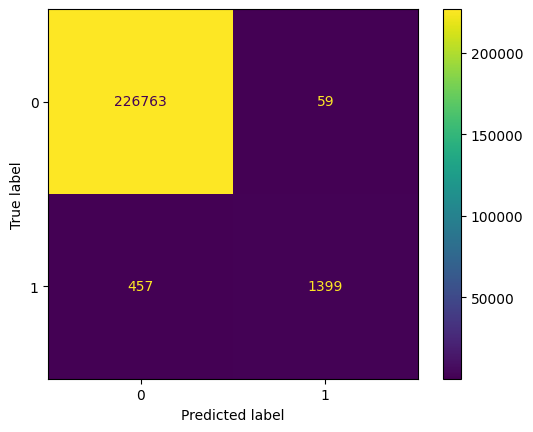

In [59]:
y_pred = gbm.predict(X_test)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

In [60]:
#plot aucroc
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

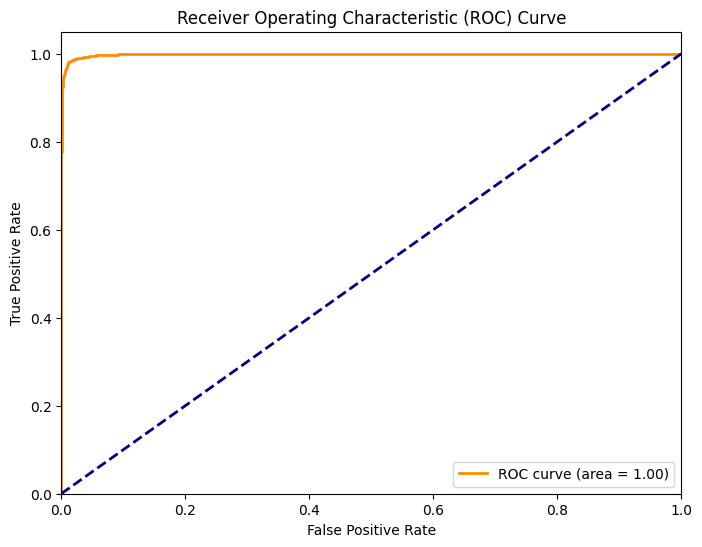

In [62]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

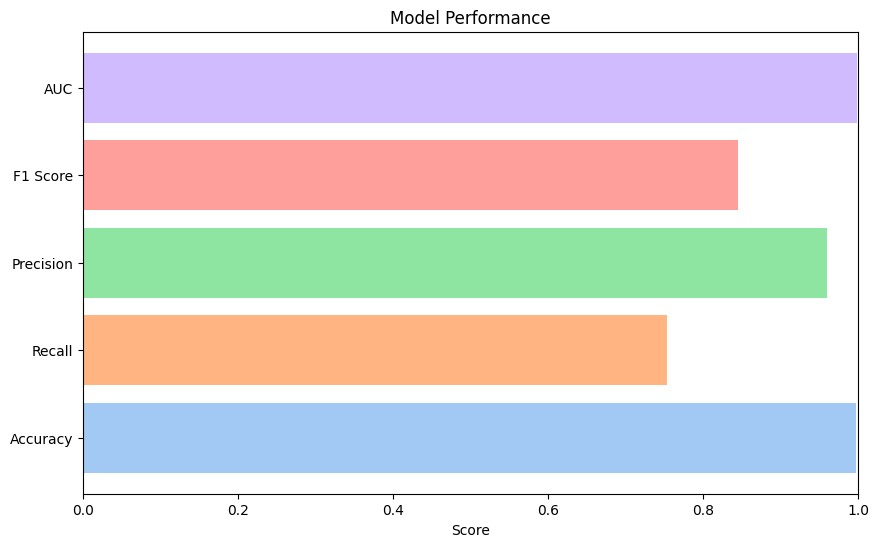

In [63]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [ ]:
lst = range(0, len(x_train_pca[0]))
lst_str = [format(x, '02d') for x in lst]
importance = pd.DataFrame({'feature': lst_str ,'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

In [ ]:
feature_importance = gbm.feature_importance()
features = lst_str
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

In [ ]:
#AUC OPTIMIZED PCA
results = pd.DataFrame({'Recall': [recall], 'Precision': [precision], 'F1 Score': [f1], 'AUC': [auc]})
#results.to_csv(path + 'LGB_PCA_factors_results_aucoptimized.csv', index=False)

best_params_df = pd.DataFrame(best_params, index=[0])
#best_params_df.to_csv(path + 'best_params_lgb_PCAfactors_aucoptimized.csv', index=False)

#gbm.save_model(path + 'model_lgb_PCAfactors_aucoptimized.txt')